# Sentiment Analysis of Arabic text


**Steps:**
1. Read raw data
2. Text preprocessing and cleaning
3. Document representation (feature vectors)
4. Build sentiment classifier based on BOW vectors
5. Build sentiment classifier based on fasstext vectors



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# set the font size of plots
plt.rcParams['font.size'] = 14



*****

## Read Arabic corpus


In [2]:
corpus_files = [ './sentiment_data_ARA_pos.txt', './sentiment_data_ARA_neg.txt' ]

In [3]:
def read_text_file(filename):
    print('Reading file ' + filename + "...")
    with open(filename, "r", encoding='utf8') as textfile:
        L = []
        for line in textfile:
            L.append(line.strip())
        print('File contains ', len(L), "lines.\n")
        return L

In [4]:
ara_corpus_pos = read_text_file(corpus_files[0]) # Positive Arabic Corpus
ara_corpus_neg = read_text_file(corpus_files[1]) # Negative Arabic Corpus

Reading file ./sentiment_data_ARA_pos.txt...
File contains  6000 lines.

Reading file ./sentiment_data_ARA_neg.txt...
File contains  4898 lines.



In [5]:
## Verify corpus

type(ara_corpus_pos),type(ara_corpus_neg)

(list, list)

In [6]:
len(ara_corpus_pos),len(ara_corpus_neg)

(6000, 4898)

In [7]:
print(ara_corpus_pos[0])
print(ara_corpus_neg[0])

مكان الرجل الحقيقي كل شي نضيف واصلي وماركات ...صح غالي شوي بس لبس روعه
المحادثات المخفية المحادثات المخفية الخاصية دي اتلغت ليه ممكن حد يفهمني


In [8]:
## Combine pos and neg corpus into a single corpus for easy manipulation

ara_corpus = ara_corpus_pos + ara_corpus_neg
ara_corpus_sentiment = len(ara_corpus_pos)*[1] + len(ara_corpus_neg)*[-1]

In [9]:
len(ara_corpus),len(ara_corpus_sentiment)

(10898, 10898)

***

## Text Preprocessing & Cleaning


1. Remove useless characters.
2. Language identification and filtering.
3. Letter normalization
4. Tokenization
5. Remove stop words
6. Word normalization (stemming)
7. Remove words that are too short or too long.

In [10]:
##1. Remove useless characters.

import re

# regexp for word elongation: matches 3 or more repetitions of a word character.
two_plus_letters_RE = re.compile(r"(\w)\1{1,}", re.DOTALL)
three_plus_letters_RE = re.compile(r"(\w)\1{2,}", re.DOTALL)
# regexp for repeated words
two_plus_words_RE = re.compile(r"(\w+\s+)\1{1,}", re.DOTALL)


def cleanup_text(text):
    # Remove URLs
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', text)

    # Remove user mentions of the form @username
    text = re.sub('@[^\s]+', '', text)
     

    # Remove special useless characters such as _x000D_
    text = re.sub(r'_[xX]000[dD]_', '', text)

    # Replace all non-word characters (such as emoticons, punctuation, end of line characters, etc.) with a space
    text = re.sub('[\W_]', ' ', text)

    # Remove redundant white spaces
    text = text.strip()
    text = re.sub('[\s]+', ' ', text)

    # normalize word elongations (characters repeated more than twice)
    text = two_plus_letters_RE.sub(r"\1\1", text)

    # remove repeated words
    text = two_plus_words_RE.sub(r"\1", text)

    return text

# unit test of this function
print(ara_corpus[0])
print(cleanup_text(ara_corpus[0]))

مكان الرجل الحقيقي كل شي نضيف واصلي وماركات ...صح غالي شوي بس لبس روعه
مكان الرجل الحقيقي كل شي نضيف واصلي وماركات صح غالي شوي بس لبس روعه


In [11]:
# Apply this function to each document in the corpus
ara_corpus_clean =  [cleanup_text(doc) for doc in ara_corpus]

In [12]:
assert(len(ara_corpus_clean)==len(ara_corpus))
print(ara_corpus_clean[0])

مكان الرجل الحقيقي كل شي نضيف واصلي وماركات صح غالي شوي بس لبس روعه


In [13]:
##2. Language identification and filtering

# Remove documents that contain more than 40% latin characters
MAX_LAT_FRAC = 0.3
ara_corpus_clean = [doc for doc in ara_corpus_clean if (len(re.findall('[a-zA-Z]',doc)) / len(doc)) < MAX_LAT_FRAC]


In [14]:
assert(len(ara_corpus_clean)<=len(ara_corpus))
print(len(ara_corpus),len(ara_corpus_clean))
print(ara_corpus_clean[0])

10898 10773
مكان الرجل الحقيقي كل شي نضيف واصلي وماركات صح غالي شوي بس لبس روعه


In [15]:
##3. Letter normalization

def normalizeArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    return(text)

ara_corpus_clean_norm =  [normalizeArabic(doc) for doc in ara_corpus_clean]
ara_corpus_clean= ara_corpus_clean_norm


In [16]:
##4. Tokenization 


from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer('[^_\W]+')
ara_corpus_tokenized = [tokenizer.tokenize(doc.lower()) for doc in ara_corpus_clean]


In [17]:
# verify corpus after tokenization
assert(len(ara_corpus_clean) == len(ara_corpus_tokenized))
assert(type(ara_corpus_tokenized[0]) == list and type(ara_corpus_tokenized[0][0]) ==str)

In [18]:
# verify first document in corpus
ara_corpus_tokenized[0]

['مكان',
 'الرجل',
 'الحقيقي',
 'كل',
 'شي',
 'نضيف',
 'واصلي',
 'وماركات',
 'صح',
 'غالي',
 'شوي',
 'بس',
 'لبس',
 'روعه']

In [19]:
##5. Remove stop words, based on a 'standard' list of stopwords for the Arabic language.


# Load stop words from NLTK library
from nltk.corpus import stopwords
stop_words_ar = stopwords.words('arabic')
type(stop_words_ar),len(stop_words_ar)
print(stop_words_ar[0:10])
#print(stop_words_ar)




# For each document, remove stop words
ara_corpus_tokenized =  [[word for word in doc  if word not in stop_words_ar] for doc in ara_corpus_tokenized]



['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي']


In [20]:
# verify corpus after removing stop words
assert(len(ara_corpus_clean) == len(ara_corpus_tokenized))
assert(type(ara_corpus_tokenized[0]) == list and type(ara_corpus_tokenized[0][0]) ==str)

In [21]:
# verify first document
ara_corpus_tokenized[0]

['مكان',
 'الرجل',
 'الحقيقي',
 'شي',
 'نضيف',
 'واصلي',
 'وماركات',
 'صح',
 'غالي',
 'شوي',
 'لبس',
 'روعه']

In [22]:
##7. Remove words that are too short or too long.
# Very short words are usually not very meaningful.
# Very long words are usually either wrong, or elongated, or derived words that should be stemmed (normalized).


distinct_words = {word for doc in ara_corpus_tokenized for word in doc}
type(distinct_words),len(distinct_words)

words_len = pd.Series([len(word) for word in distinct_words])
words_len.describe()

count    69772.000000
mean         5.843290
std          1.643354
min          1.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         30.000000
dtype: float64

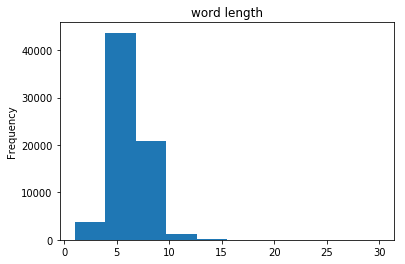

In [23]:
fig = words_len.plot(kind='hist', title="word length")

In [24]:
[word for word in distinct_words if len(word)<=2]

['50',
 'شم',
 'وس',
 'عز',
 'ـ',
 'شي',
 'cg',
 'خب',
 '81',
 'رش',
 'كـ',
 'لل',
 'سد',
 '33',
 'بف',
 'شق',
 'ب6',
 '0',
 'دل',
 'حب',
 'le',
 'صب',
 '05',
 'رك',
 'فخ',
 'mr',
 'ﻻن',
 'طر',
 'عر',
 '5',
 'اة',
 'g3',
 'شد',
 '17',
 'حة',
 'حق',
 '55',
 '3',
 'ل4',
 'تا',
 's',
 'جو',
 'ضي',
 'طه',
 'مر',
 'و4',
 'm',
 'خو',
 '٢٢',
 'سن',
 '41',
 'جت',
 '40',
 'يم',
 'مد',
 'اﻻ',
 'جن',
 '٦',
 '25',
 'طة',
 'وا',
 'ذم',
 'طن',
 'دي',
 '٢٦',
 'ii',
 '07',
 'm3',
 '78',
 'زم',
 '45',
 'سو',
 'مو',
 'وش',
 'at',
 '١٩',
 'و2',
 'جة',
 'كو',
 'عم',
 '١٧',
 'فض',
 'فا',
 'اد',
 'يف',
 'نس',
 'و',
 'اي',
 '85',
 'a4',
 'ز',
 'غ',
 'el',
 'و٥',
 'ح',
 'خم',
 'مي',
 '٦٩',
 'وي',
 '79',
 '١٦',
 'صن',
 'نع',
 '46',
 'ڼ',
 'بر',
 'حل',
 'ب٣',
 'i',
 '٤',
 'فت',
 'طف',
 'ذ',
 'قل',
 'ب5',
 'قص',
 'wo',
 'كب',
 '27',
 'د',
 'شر',
 'سي',
 'ال',
 '83',
 'ءد',
 'رب',
 'تن',
 'اش',
 '58',
 'dg',
 'al',
 'ط',
 'جر',
 'بـ',
 '٣٣',
 'u',
 'شا',
 'وم',
 'de',
 'غض',
 'وص',
 'ذق',
 'تو',
 'كر',
 '٦٠',
 'غ

In [25]:
[word for word in distinct_words if len(word)>=12]

['الاخرلايسمعني',
 'الراءعوالمكان',
 'لاتوجدارشادات',
 'وقطعهامناسبه',
 'ممتازللاقامة',
 'والكونتيننتال',
 'الالكترونيات',
 'الفيديوبيبقي',
 'وبيترايونولا',
 'الاليكتروستاتيكية',
 '14نوفمبر2013',
 'وتليفزيوناتها',
 'جداالتكييفات',
 'الانتركونتينينتال',
 'الكونتيننتال',
 'الاسكندرانية',
 'العلويةمنعني',
 'ممتازةالسلعة',
 'الخيارالطازج',
 'والشاطءوالحمامات',
 'بيراميدزجولف',
 'jormandsuitesdubai',
 'بالالكترونيات',
 'propertyindex',
 '8114بالاضافه',
 'riyadhsamzy08',
 'كورفورشتيندام',
 'بخامتهاالممتازة',
 'وتعاملهاالراقي',
 'ميزانيةالشخص',
 'نظيفةالقاءمة',
 'حدولاحديسمعني',
 'الحماموالارض',
 'لالالالالالالالالالالالالالالا',
 'بالسعرالمنخفض',
 'بالبورصةوالله',
 'الاعمارواهتمامهم',
 'التايلانديون',
 'الممتازةessam',
 'للاسراءيليين',
 'مدينةالمتاحف',
 '100x100جربوه',
 'البروتوكولات',
 'الاسكتلنديين',
 'الاستثناءيين',
 'ابوبكرالصديق',
 'booklagostransfers',
 'induransاسعدني',
 'دقيقةبالسيارة',
 '738014900خبير',
 'والاسعارمرتفعة',
 'وتشريدواقصاء',
 'وتوجدمواصلات',
 'الانتركونتننتال',
 'والثل

In [26]:
# remove words that contain <= 2 characters
ara_corpus_tokenized_1 = [[word for word in doc if len(word)>=2] for doc in ara_corpus_tokenized]
type(ara_corpus_tokenized_1),len(ara_corpus_tokenized_1)

(list, 10773)

In [27]:
# remove words that contain >= 12 characters
ara_corpus_tokenized_2 = [[word for word in doc if len(word)<=12] for doc in ara_corpus_tokenized_1]
type(ara_corpus_tokenized_2),len(ara_corpus_tokenized_2)

(list, 10773)

In [28]:
from snowballstemmer import stemmer
ar_stemmer = stemmer("arabic")



In [29]:
ara_corpus_tokenized_3=[[ar_stemmer.stemWord(word) for word in doc] for doc in ara_corpus_tokenized_2]

In [30]:
ara_corpus_tokenized=ara_corpus_tokenized_3
ara_corpus_tokenized

[['مكان',
  'رجل',
  'حقيق',
  'شي',
  'نضيف',
  'واصل',
  'ماركا',
  'صح',
  'غال',
  'شو',
  'لبس',
  'روع'],
 ['جيد',
  'جدا',
  'المك',
  'يتمتع',
  'طاقم',
  'ضياف',
  'عل',
  'مستو',
  'عال',
  'دخول',
  'وهم',
  'استقبل',
  'ابتسام',
  'يتمتع',
  'موسيق',
  'هادء',
  'عندم',
  'يكون',
  'مطعم',
  'ممتليء',
  'ولك',
  'لاحظ',
  'عكس',
  'امتلاء',
  'واتوقع',
  'ان',
  'يجعل',
  'زباء',
  'تاكل',
  'سرع',
  'اكبر',
  'يتوافر',
  'اما',
  'اخر',
  'لغير',
  'نسب',
  'اكل',
  'فهو',
  'مذاق',
  'جميل',
  'طيب',
  'لحط',
  'اول',
  'تشعر',
  'بان',
  'كم',
  'اكل',
  'كاف',
  'غير',
  'مناسب',
  'سعر',
  'داي',
  'اكل',
  'تشعر',
  'جود',
  'تشعر',
  'بان',
  'الكم',
  'معقول',
  'فعل',
  'جلس',
  'مريح',
  'جدا',
  'واسعار',
  'مناسب',
  'نسب',
  'لجود',
  'اكل'],
 ['ندق',
  'راءع',
  'واقع',
  'فندق',
  'راءع',
  'كذل',
  'عامل',
  'اروع',
  'ناح',
  'تعامل',
  'خدم',
  'غرف',
  'نظيف',
  'ولك',
  'ضيق',
  'نوع',
  'نادق',
  'نيويور',
  'عجب',
  'ايض',
  'فطور',
  'صباح',
  'موقع',

****

## Document Representation
The goal of this step is to transform each document from a list of words to a numeric *feature vector*. Each feature corresponds to a distinct word in a selected vocabulary. These feature vectors are stored in a numeric matrix:  **Document-Term Matrix (DTM)**.


#### Prepare the corpus for BOW

In [31]:
# First, concatenate the words in the cleaned corpus (because BOW method in scikit-learn requires this format)
ara_corpus_bow = [' '.join(doc) for doc in ara_corpus_tokenized]

In [32]:
assert(len(ara_corpus_tokenized)==len(ara_corpus_bow))

In [33]:
print(ara_corpus_tokenized[0])

['مكان', 'رجل', 'حقيق', 'شي', 'نضيف', 'واصل', 'ماركا', 'صح', 'غال', 'شو', 'لبس', 'روع']


In [34]:
print(ara_corpus_bow[0])

مكان رجل حقيق شي نضيف واصل ماركا صح غال شو لبس روع


#### Build the vocabulary set
Extract the vocabulary set from our corpus and calculate IDF values of each word in this set.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
# Configuration parameters of the BOW model
max_words = 10000
maxdf = 0.7
mindf = 5

In [37]:
# create an instance of this class
bow_model = TfidfVectorizer(max_df=maxdf, min_df=mindf, max_features=max_words, stop_words=[], use_idf = True)

In [38]:
# call fit() method in order to prepare BOW method (determine vocabulary and IDF values)
bow_model.fit( ara_corpus_bow )

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=10000, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=[], strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

#### Build the DTM matrix

In [39]:
# Call the transform method in order to calculate DTM matrix of our corpus
ara_bow_dtm = bow_model.transform(ara_corpus_bow)

In [40]:
# Verify the type and size of this matrix
print(type(ara_bow_dtm))
print(ara_bow_dtm.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(10773, 7974)


#### Visually inspect the vocabulary
This should help us **tune** the BOW configuration parameters (i.e. min_df, max_df, etc.) ...

In [41]:
# The vocabulary of BOW: the words that were selected by BOW method to be in the vocabulary

bow_vocab = bow_model.get_feature_names()
type(bow_vocab), len(bow_vocab)

(list, 7974)

In [42]:
# The words that were ignored (and were not included in the vocabulary)
ignored_words = bow_model.stop_words_
type(ignored_words),len(ignored_words)

(set, 21550)

In [43]:
# Put vocavulary and their IDF values in a data frame
df = pd.DataFrame(dict(Word=bow_vocab,IDF=bow_model.idf_))

In [44]:
df.head()

,IDF,Word
0,6.372868,00
1,8.205450,01
2,8.493132,03
3,7.982306,05
4,8.205450,07


In [45]:
df.tail()

,IDF,Word
7969,7.886996,يومان
7970,5.699924,يومي
7971,5.514206,يومين
7972,8.493132,يوميه
7973,6.673973,يون


In [46]:
# Show vocabulary words that have SMALLEST IDF values (i.e. that have the largest document frequencies)
df.sort_values("IDF", inplace=False, ascending = True).head(10)

,IDF,Word
4407,1.950900,عل
4923,2.076399,كان
2513,2.081040,جدا
1121,2.157782,ان
4695,2.191429,فندق
918,2.242513,ال
4517,2.262978,غرف
3180,2.397307,راءع
2648,2.486368,جيد
2928,2.559561,خدم


In [47]:
# Show vocabulary words that have LARGEST IDF values (i.e. that have the smallest document frequencies)
df.sort_values("IDF", inplace=False, ascending = False).head(10)

,IDF,Word
7137,8.493132,والقر
2039,8.493132,تشك
2484,8.493132,جاك
2476,8.493132,جات
7204,8.493132,وثا
2462,8.493132,ثوا
2460,8.493132,ثمين
7205,8.493132,وثم
2455,8.493132,ثلوج
2452,8.493132,ثلاجه


In [48]:
# If you want, you can save the vocabulary into a file
df.sort_values("IDF", inplace=False, ascending = True).to_csv("./bow_vocab.csv", index=False, header=True)

#### Remove documents that do not contain any vocabulary terms
Remove rows in the DTM that are all zeros.

In [49]:
nb_terms_per_doc = np.array((ara_bow_dtm>0).sum(axis=1))  # calculate sum of rows of DTM matrix
nb_terms_per_doc = nb_terms_per_doc.ravel()  # convert result to a 1D array (instead of 2D array)
ara_bow_dtm.shape,nb_terms_per_doc.shape

((10773, 7974), (10773,))

In [50]:
pd.Series(nb_terms_per_doc).describe()

count    10773.000000
mean        39.105913
std         35.523667
min          0.000000
25%         14.000000
50%         30.000000
75%         52.000000
max        469.000000
dtype: float64

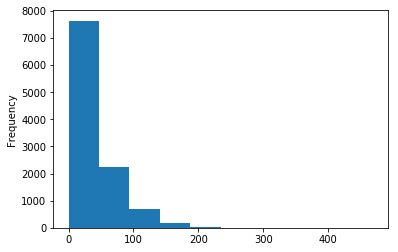

In [51]:
pd.Series(nb_terms_per_doc).plot(kind='hist')

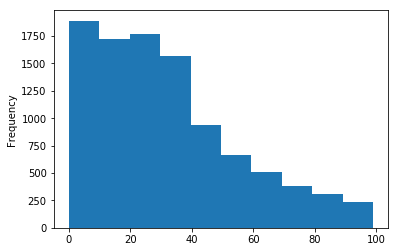

In [52]:
pd.Series(nb_terms_per_doc[nb_terms_per_doc<100]).plot(kind='hist')

In [53]:
# Number of documents that contain LESS THAN 5 vocabulary term
np.sum(nb_terms_per_doc<=5)

1097

In [54]:
# Number of documents that contain ZERO vocabulary terms
np.sum(nb_terms_per_doc==0)

26

In [55]:
# Which documents have length 0? (i.e. contain 0 words)
[doc for i,doc in enumerate(ara_corpus_bow) if nb_terms_per_doc[i]==0]

['ووه',
 'ودر كولاج',
 'ممتازز',
 '7عغ',
 'حميل',
 'حن',
 'ياخروف',
 'طز',
 'كسم',
 'ملعون',
 'خاين',
 '',
 '',
 'خراط',
 'معترض',
 'اخرف',
 'كسم',
 'طظ',
 'عبيط',
 'طظ',
 'طرطور',
 'نيفس تهف تعك',
 'ماتشتغل',
 'شكرل',
 'ممتازةوش',
 'اا']

In [56]:
idx = nb_terms_per_doc>0
ara_bow_dtm_filt = ara_bow_dtm[nb_terms_per_doc>0,:]
ara_corpus_bow_filt = [ara_corpus_bow[i] for i,x in enumerate(idx) if x]
ara_corpus_sentiment_filt = [ara_corpus_sentiment[i] for i,x in enumerate(idx) if x]

In [57]:
ara_bow_dtm.shape,len(ara_corpus_bow)

((10773, 7974), 10773)

In [58]:
ara_bow_dtm_filt.shape,len(ara_corpus_bow_filt),len(ara_corpus_sentiment_filt)

((10747, 7974), 10747, 10747)

******

## Build Sentiment Classifier
We will use the machine learning approach (Logistic Regression).

In [59]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [60]:
X = ara_bow_dtm_filt
y = ara_corpus_sentiment_filt

In [61]:
# Split the data into training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1996)

In [62]:
print(X_train.shape)
print(len(y_train))
print(X_test.shape)
print(len(y_test))
assert(len(y_test)+len(y_train)==len(y))

(7522, 7974)
7522
(3225, 7974)
3225


### Train the logistic regression model

In [63]:
# Train the model

LR_model = LogisticRegression(penalty='l2')
LR_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [64]:
# Use this model to predict the sentiment category of test documents
y_pred_LR = LR_model.predict(X_test)

In [65]:
type(y_pred_LR),len(y_pred_LR)

(numpy.ndarray, 3225)

In [66]:
# Calculate the classification rate of this classifier
metrics.accuracy_score(y_test, y_pred_LR)

0.897984496124031

In [67]:
# Display the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_LR))

[[1299  174]
 [ 155 1597]]


### Interpret parameter values of  this model
- The logistic regression model has one parameter per feature (i.e. vocabulary word).
- Most positive values indicate parameters that contribute most to class 1
- Most negative values indicate parameters contribute most to class -1

In [68]:
# Re-train the model using ALL DATA
LR_model2 = LogisticRegression(penalty='l2')
LR_model2.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [69]:
# get the coefficients (parameter) of the LR model
LR_coefs = LR_model2.coef_   #2D array with only one row
LR_coefs = LR_coefs.ravel()  #convert to a 1D array
print(type(LR_coefs))
print(LR_coefs.shape)

<class 'numpy.ndarray'>
(7974,)


In [70]:
# Verify that the number of coefficients = number of words in vocabulary
assert(len(bow_model.get_feature_names())==len(LR_coefs))

In [71]:
# Put the coefficients in a Pandas Series for ease of visualization
pd.Series(LR_coefs).describe()

count    7974.000000
mean        0.013828
std         0.456505
min        -9.507802
25%        -0.159745
50%         0.006778
75%         0.175247
max         9.380236
dtype: float64

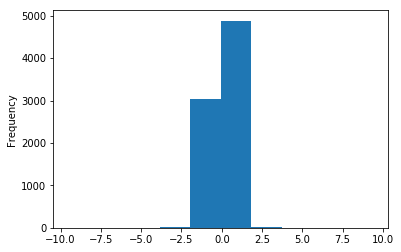

In [72]:
pd.Series(LR_coefs).plot(kind='hist')

In [73]:
# 1) Sort coefficient values in ascending order
df = pd.DataFrame(dict(Word=bow_vocab, Coef=LR_coefs))
df1=df.sort_values("Coef", inplace=False, ascending = True)
# 2) Display the 20 largest coefficients and their corresponding words
print(df1.tail(20))

# 3) Display the 20 smallest coefficients and their corresponding words

print(df1.head(20))

          Coef   Word
7032  2.378844   واسع
3683  2.398203     سن
264   2.422624    احب
440   2.432039   اروع
5196  2.457470   لذيذ
6349  2.684056   مميز
6335  2.739436   ممتع
251   2.743961   اجمل
5232  2.779034   لطيف
828   2.792502   افضل
3469  2.810829   زيار
3208  2.815524    راق
2592  2.937263   جميع
5830  3.272241   مريح
3882  3.388947    شكر
3368  3.501698    روع
2648  4.307036    جيد
2593  5.147439   جميل
6332  6.983982  ممتاز
3180  9.380236   راءع
          Coef   Word
3729 -9.507802    سيء
129  -3.961492    ابد
5936 -3.576221     مش
615  -3.572484    اسو
4791 -3.494963    قذر
586  -3.008492    اسف
4248 -2.806696    عاد
2708 -2.766320     حت
616  -2.729691   اسوء
3274 -2.671108   رديء
4495 -2.578522    غال
3480 -2.515082     سء
6451 -2.491506     مو
4094 -2.446041   ضعيف
5481 -2.325408  مبالغ
4788 -2.238027   قديم
2719 -2.176210    حجز
3552 -2.147538    سبب
723  -2.139759  اطلاق
3074 -2.041206    دفع


### Train classifier using Naive Bayes

In [74]:
## Build Naive Bayes classification model

NB_model = MultinomialNB(alpha = 1.0)
NB_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [75]:
# Use this model to predict the sentiment category of test documents
y_pred_NB = NB_model.predict(X_test)

In [76]:
# Classification rate
metrics.accuracy_score(y_test, y_pred_NB)

0.8703875968992248

In [77]:
# Confusion matrix
metrics.confusion_matrix(y_test, y_pred_NB)

array([[1170,  303],
       [ 115, 1637]])

### Interpret parameters of  the model
- Naive Bayes model has two parameters per feature (i.e. vocabulary word)
- These parameters are stored in a 2x$n$ array, where $n$ is the number of vocabulary words
- The first row of this array contains **log of conditional probabilities** Pr(xi|class1)
- The second row contains **log of conditional probabilities** Pr(xi|class2)
- Ideally, if parameter value $\approx$ 0 then the corresponding vocabulary word is very important for that class
- Ideally, if parameter value $\approx - \infty$ then the corresponding vocabulary word is not important at all for that class

In [78]:
# Re-train the model using ALL DATA
NB_model2 = MultinomialNB(alpha = 1.0)
NB_model2.fit(X, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [79]:
# get NB model's coefficients
NB_coefs = NB_model2.feature_log_prob_
print(type(NB_coefs))
print(NB_coefs.shape)

<class 'numpy.ndarray'>
(2, 7974)


In [80]:
assert(NB_coefs.shape[0] == 2)
assert(NB_coefs.shape[1] == len(bow_model.get_feature_names()))

In [81]:
# determine the order of classes in this model
NB_model2.classes_

array([-1,  1])

In [82]:
# paramaters associated with the NEGATIVE class
NB_coefs_neg_class = NB_coefs[0,:]

In [83]:
# paramaters associated with the POSITIVE class
NB_coefs_pos_class = NB_coefs[1,:]

In [84]:
pd.Series(NB_coefs_neg_class).describe()

count    7974.000000
mean       -9.416942
std         0.762129
min       -10.394182
25%        -9.951007
50%        -9.618419
75%        -9.076470
max        -5.102402
dtype: float64

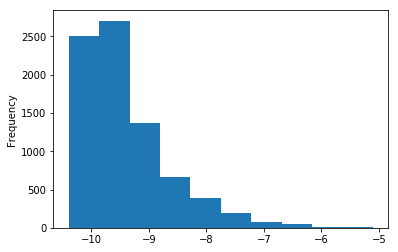

In [85]:
pd.Series(NB_coefs_neg_class).plot(kind='hist')

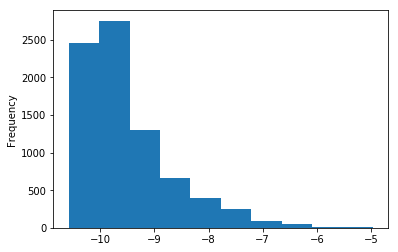

In [86]:
pd.Series(NB_coefs_pos_class).plot(kind='hist')

In [87]:
# Sort the coefficient values of the POSITIVE CLASS in ascending order
df_pos = pd.DataFrame(dict(Word=bow_vocab, Coef=NB_coefs_pos_class))
df_pos1=df_pos.sort_values("Coef", inplace=False, ascending = True)
# 2) Display the 20 largest coefficients and their corresponding words
print(df_pos1.tail(20))

# 3) Display the 20 smallest coefficients and their corresponding words

print(df_pos1.head(20))



# Repeat the same thing for the coefficients of the negative class


df_neg = pd.DataFrame(dict(Word=bow_vocab, Coef=NB_coefs_neg_class))
df_neg1=df_neg.sort_values("Coef", inplace=False, ascending = True)
# 2) Display the 20 largest coefficients and their corresponding words
print(df_neg1.tail(20))

# 3) Display the 20 smallest coefficients and their corresponding words

print(df_neg1.head(20))




          Coef   Word
1179 -6.103180   انصح
6732 -6.089052   نظيف
6243 -6.049982   مكان
6045 -6.037486   مطعم
4454 -6.035806    عند
6501 -5.992551   موقع
2592 -5.937782   جميع
2928 -5.732361    خدم
6650 -5.692515    ندق
1121 -5.599316     ان
4517 -5.575675    غرف
918  -5.565375     ال
2593 -5.476514   جميل
2648 -5.311230    جيد
4407 -5.310132     عل
6332 -5.267103  ممتاز
4695 -5.214227   فندق
4923 -5.155944    كان
2513 -5.054354    جدا
3180 -4.960379   راءع
           Coef    Word
4738 -10.586272    قاءل
5207 -10.586272     لسا
2716 -10.586272     حجت
7873 -10.586272     يلغ
588  -10.586272   اسفين
589  -10.586272   اسقاط
4572 -10.586272   فاخبر
4568 -10.586272  فاتوره
5226 -10.586272    لصوص
4557 -10.586272     فءر
5203 -10.586272     لزج
4554 -10.586272     غيض
2788 -10.586272     حطي
595  -10.586272     اسل
596  -10.586272   اسلاك
7882 -10.586272   يماطل
2812 -10.586272    حقير
7883 -10.586272     يمت
2818 -10.586272    حكال
5680 -10.586272    محدش
          Coef  Word
1122 -6.24392

****